#### **Влияние авторских прав и pre-print публикаций научных статей на цитируемость в космической физике.**

Выполнил: Мухин Андрей Анатольевич.

В рамках данной работы рассматривается на базовом уровне влияние двух независимых факторов, связанных с публикацией научной статьи:
1. В рамках какого авторского права статья была опубликована издателем.<br>
В данном случае рассматривается только два варианта, наиболее распространенные в области:
- **Сохранение авторских прав** и публикация в рамках CC-BY (различных версий в зависимости от журнала и времени).
- **Передача части прав журналу/издателю** в рамках предложенного журналом/издателем соглашения, например,<br>
[такого](https://www.spiedigitallibrary.org/documents/Journals/JournalsCopyrightTransfer.pdf) (ссылка на скачивание).

2. Был ли опубликован пре-принт публикации на бесплатном сервере Arxiv.<br>
В данном случае также рассматривается всего два варианта:
- У опубликованной статьи **есть ассоциированный с ней препринт** на сайте Arxiv.
- У опубликованной статьи **нет препринта** на сайте Arxiv.

**Ключевая задача данной работы** &mdash; определить наиболее выигрышную стратегию с точки зрения цитируемости при подаче статьи в журнал с двумя вариантами передачи авторского права, а также оценить важность публикации пре-принтов на открытых и популярных серверах.

#### **Подготовка к работе**

В качестве данных для анализа использована база [NASA/ADS (Astrophysics data system)](https://ui.adsabs.harvard.edu/), информация из которой обработана при помощи её открытого [API](https://ui.adsabs.harvard.edu/help/api/) и некоторых модулей Python.

Если импорты ниже не работают, попробуйте в консоли использовать команду:<br>
`pip install -r requirements.txt`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from urllib.parse import urlencode, quote_plus
import requests

Для работы с API NASA/ADS необходимо зарегистрироваться в базе данных и сгенерировать [индивидуальный токен](https://ui.adsabs.harvard.edu/user/settings/token).

In [2]:
# ====================================

TOKEN = 'INSERT_YOUR_KEY_HERE'

# ====================================

API_URL = 'https://api.adsabs.harvard.edu/v1/'

Ниже описаны функции для выполнения:<br>
`question` - базовых запросов к API по URL и словарем, содержащим информацию о запросе.

`journal_cheсk` - полная процедура подготовки данных по журналу для отрисовки графика или дальнейшего анализа по bibstem журнала (см. [ссылку](https://adsabs.harvard.edu/abs_doc/journals1.html#)).

`plot_stats` - функция для отрисовки графика цитирований от года для предоставленных данных.

In [3]:
def question(url, query=None):
    if query:
        encoded_query = urlencode(query)
        results = requests.get(f'{API_URL}/{url}?{encoded_query}',
                        headers={'Authorization': 'Bearer ' + TOKEN})
    else:
        results = requests.get(f'{API_URL}/{url}',
                        headers={'Authorization': 'Bearer ' + TOKEN})

    return results.json()


def journal_check(journal_bibstem):
    query = {
        "q":f"bibstem:{journal_bibstem}",
        "rows":2000,
        "fl":"title, copyright, citation_count, year, alternate_bibcode"
    }
    results = question('search/query', query)
    # results

    df = pd.DataFrame(results['response']['docs'])

    df['citation_count'] = df['citation_count'].fillna(0.)
    df['free_copy'] = df.copyright.str.contains('Author|Creative Commons', case=False)
    df['arxiv'] = ~df.alternate_bibcode.isna()
    df['pub_type'] = df.free_copy + 2*df.arxiv

    return df.copy()


def plot_stats(df, plot_type='median', years=None):
    colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green']
    labels = ['Jour + no arxiv', 'CC + no arxiv', 'Jour + arxiv', 'CC + arxiv']
    
    plt.close()
    
    plt.figure(figsize=(15, 10))
    
    for i in range(4):
        df_pub_type = df[df.pub_type == i]        
        grouped_df = df_pub_type.groupby('year', as_index=False)

        if plot_type == 'median':
            table_median = grouped_df.citation_count.median()
            table_q25 = grouped_df.citation_count.quantile(0.25)
            table_q75 = grouped_df.citation_count.quantile(0.75)
            plt.errorbar(table_median.year.astype(int), table_median.citation_count,
                        [table_q25.citation_count, table_q75.citation_count],
                        color=colors[i], label=labels[i])
        
        if plot_type == 'mean':
            table_mean = grouped_df.citation_count.mean()
            table_std = grouped_df.citation_count.std()
            plt.errorbar(table_mean.year.astype(int), table_mean.citation_count,
                        table_std.citation_count,
                        color=colors[i], label=labels[i])
    plt.ylabel('Медианное число цитирований в этом году')
    plt.xlabel('Год')
    plt.legend()
    plt.yscale('symlog')
    if years:
        plt.xlim(years[0], years[1])
    plt.show()

#### **Исследование.**

До начала работы необходимо учесть, что различные журналы обладают различной публикационной привлекательностью сами по себе, поскольку относятся к разным квартилям, дольше существуют и т.д., поэтому, для работы только в рамках системы с двумя параметрами (авторское право и наличие препринта) будем сравнивать между собой исключительно метрики для одного и того же журнала:

Некоторые издатели в рамках своей работы предлагают авторам **гибридный формат подачи статей**:<br>
Авторы могут выбрать заплатить определенную сумму на покрытие работы издательства и опубликовать работу в **Open Access**.<br>
При этом большинство журналов оставляет за авторами все права на работу и распространяет публикацию в рамках **CC-BY**.<br>
Если же авторы выбирают не платить за публикацию, их **права на их работу переходят издателю** в рамках соглашения о передаче прав, а сама статья публикуется в ограниченном доступе для подписчиков журнала.<br>
Таким образом, в рамках одного журнала могут существовать **публикации с разными авторскими правами**.

Вопрос публикации препринта публикации также может регулироваться издателем, поэтому работы рассмотрим только журналы, в которых **публикация препринта разрешена**, и для которых мы можем сравнить между собой публикации с и без препринтов.

В результате небольшого исследования было найдено несколько журналов (но ими список, конечно, не ограничивается), которые попадают под наши критерии:
- Journal of Astronomical Telescopes, Instruments and Systems
- Astronomy & Computing
- New Astronomy
- Icarus

##### **Методика**
Для анализа данных сначала совершается запрос на сервер по `bibstem` журнала, в качестве ответа принимается следующая информация обо всех публикациях:
1. название статьи,
2. год публикации,
3. число цитирований,
4. альтернативный библиографический код<br>
(который является однозначным указателем на публикацию препринта в Arxiv),
5. короткое заявление об авторском праве.

Далее заявление об авторском праве анализируется на предмет наличия заявления о том, что права принадлежат авторам.<br>
Если это так, то статье присваивается статус `free_copy = True`, в противном случае `False`.

Аналогичным образом, если у статьи есть альтернативный библиографический код, то ей присваеивается статус о наличии препринта на Arxiv в виде `arxiv = True`, в противном случае `False`.

Наконец, эта пара бинарных параметров переводится в одно число, классифицирующее публикацию по типу:<br>
```
pub_type = 

0 если (Jour copyright) AND ( no arxiv)
1 если (  CC copyright) AND ( no arxiv)
2 если (Jour copyright) AND (has arxiv)
3 если (  CC copyright) AND (has arxiv)
```

Далее при помощи функции `plot_stats` на графике изображается медианное значение цитирований с 25 и 75 процентилями для каждого года публикаций и для каждого из типов публикацией из продемонстрированных четырех.

По итогам рассмотрения этого графика можно сделать вывод о привлекательности каждого из видов публикаций для конкретного журнала.

##### **Journal of Astronomical Telescopes, Instruments and Systems**
Журнал, посвященный техническим аспектам космической физики:<br>
разработке ПО, конструированию приборов, датчиков и т.д.<br>
Статистика взята из [scimago](https://www.scimagojr.com/journalsearch.php?q=21100423216&tip=sid&clean=0):
```
h-index    = 29
SJR        = 0.47
Quartile   = Q2 
Cites/Doc. = 1.72
```


In [4]:
df_jatis = journal_check('JATIS')
print(f'Публикаций найдено: {len(df_jatis)}')
df_jatis.head(5)

Публикаций найдено: 806


,copyright,title,year,citation_count,alternate_bibcode,free_copy,arxiv,pub_type
0,(c) 2015: The Authors. Published by SPIE under...,[Transiting Exoplanet Survey Satellite (TESS)],2015,2511.0,NaN,True,False,1
1,(c) 2022: The Authors. Published by SPIE under...,[The Imaging X-Ray Polarimetry Explorer (IXPE)...,2022,138.0,"[2021arXiv211201269R, 2021arXiv211201269W]",True,True,3
2,(c) 2022: 2022 Society of Photo-Optical Instru...,[All-sky Medium Energy Gamma-ray Observatory e...,2022,20.0,[2022arXiv220804990C],False,True,2
3,(c) 2020: 2020 Society of Photo-Optical Instru...,[Properties and characteristics of the Nancy G...,2020,20.0,[2020arXiv200500505M],False,True,2
4,(c) 2023: 2023 Society of Photo-Optical Instru...,[Vortex fiber nulling for exoplanet observatio...,2023,0.0,[2023arXiv230906514E],False,True,2


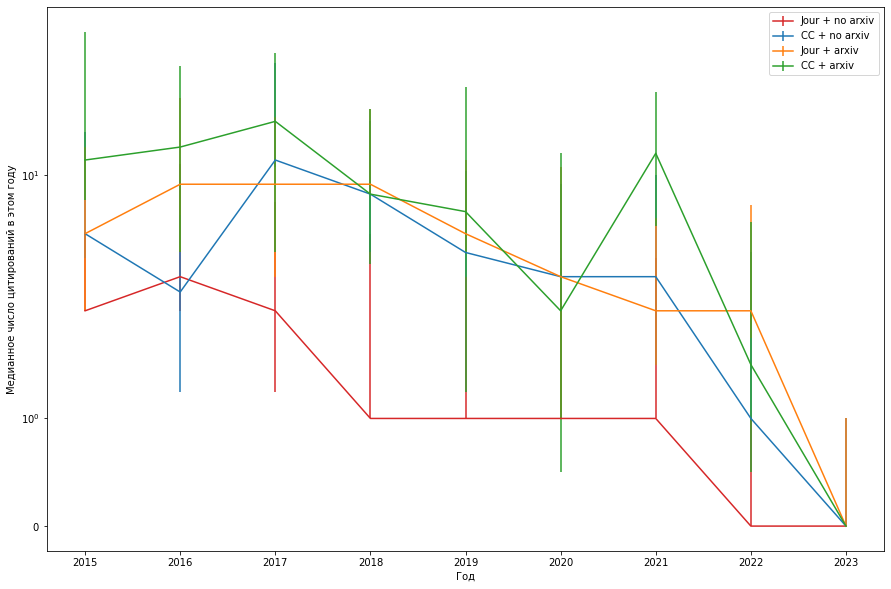

In [5]:
plot_stats(df_jatis)

**Выводы:**

На этом примере видно два принципиальных тренда на графике:
1. Во все годы публикаций журналы опубликованные в ограниченном доступе без препринтов получали медианно меньше цитирований, чем любые другие, в отдельные годы **на порядок меньше**.
2. Для этого журнала публикации в открытом или ограниченном доступе при наличии препринта на Arxiv фактически эквивалентны по своим показателям цитируемости, что дает повод предположить, что для конкретного журнала выигрышной стратегией будет не оплачивать Open Access и вместо этого выложить статью в подписочной системе и затем загрузить препринт на Arxiv.

##### **Astronomy & Computing**
Журнал, посвященный практическому применению и разработке машинных алгоритмов для работы с астрофизическими данными.<br>
Статистика взята из [scimago](https://www.scimagojr.com/journalsearch.php?q=21100241218&tip=sid&clean=0):
```
h-index    = 31
SJR        = 0.806
Quartile   = Q2 
Cites/Doc. = 2.53
```


In [6]:
df_ac = journal_check('A&C')
print(f'Публикаций найдено: {len(df_ac)}')
df_ac.head(5)

Публикаций найдено: 547


,alternate_bibcode,copyright,title,year,citation_count,free_copy,arxiv,pub_type
0,[2015arXiv151001320M],(c) 2016 Elsevier B.V.,[The EAGLE simulations of galaxy formation: Pu...,2016,416.0,False,True,2
1,[2015arXiv150400362N],(c) 2015 Elsevier B.V.,[The illustris simulation: Public data release],2015,449.0,False,True,2
2,[2014arXiv1407.7676R],(c) 2015 Elsevier B.V.,[GALSIM: The modular galaxy image simulation t...,2015,289.0,False,True,2
3,[2023arXiv230803045A],(c) 2023 Elsevier B.V.,[Machine learning methods for the search for L...,2023,0.0,False,True,2
4,[2013arXiv1306.6721M],(c) 2013 Elsevier B.V.,[HMFcalc: An online tool for calculating dark ...,2013,264.0,False,True,2


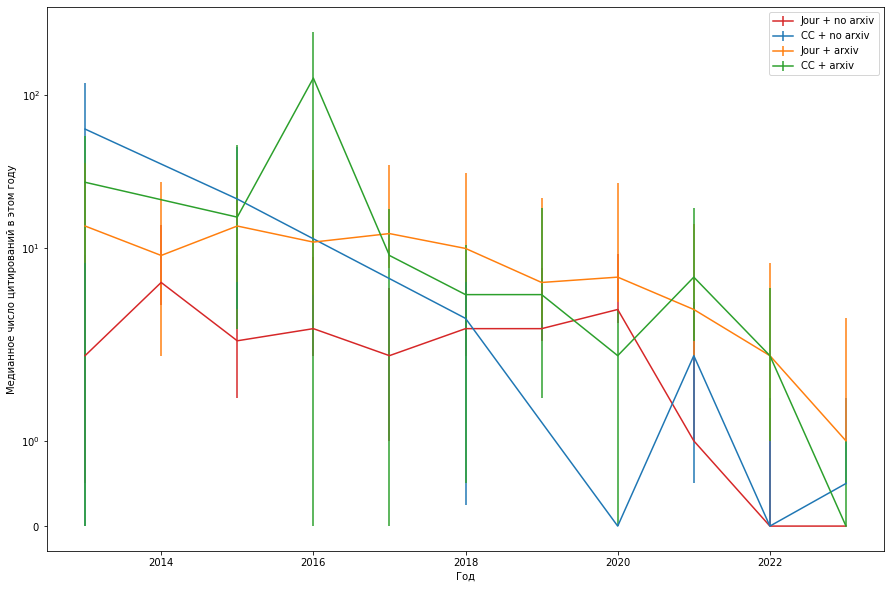

In [7]:
plot_stats(df_ac)

**Выводы:**

Вывод схож с полученным из анализа прошлого журнала: публикации, имеющие препринты на Arxiv, имеют медианно больше цитирований, чем таковые без препринта вне зависимости от авторского права. Здесь, однако, наблюдается тренд, который не фигурировал ранее: статьи в открытом доступе без препринта имеют систематически меньше цитирований, чем любые с опубликованным препринтом.

#### **Icarus**
Один из наиболее известных журналов, посвященных исследованию объектов Солнечной системы.<br>
Статистика взята из [scimago](https://www.scimagojr.com/journalsearch.php?q=27241&tip=sid&clean=0):
```
h-index    = 164
SJR        = 1.241
Quartile   = Q1 
Cites/Doc. = 3.16
```

In [8]:
df_icar = journal_check('Icar')
print(f'Публикаций найдено: {len(df_icar)}')
df_icar.head(5)

Публикаций найдено: 2000


,copyright,title,year,citation_count,alternate_bibcode,free_copy,arxiv,pub_type
0,(c) 1998 Academic Press,[Active Volcanism on Io as Seen by Galileo SSI],1998,171,NaN,False,False,0
1,(c) 1996 Academic Press,[Formation of the Giant Planets by Concurrent ...,1996,2393,NaN,False,False,0
2,(c) 1993 Academic Press,[Habitable Zones around Main Sequence Stars],1993,1653,NaN,False,False,0
3,(c) 2020 Elsevier Inc.,[Spinning up planetary bodies by pebble accret...,2020,6,[2019arXiv190704368V],False,True,2
4,(c) 1979 Elsevier Science B.V. All rights rese...,[Radiation forces on small particles in the so...,1979,1179,NaN,False,False,0


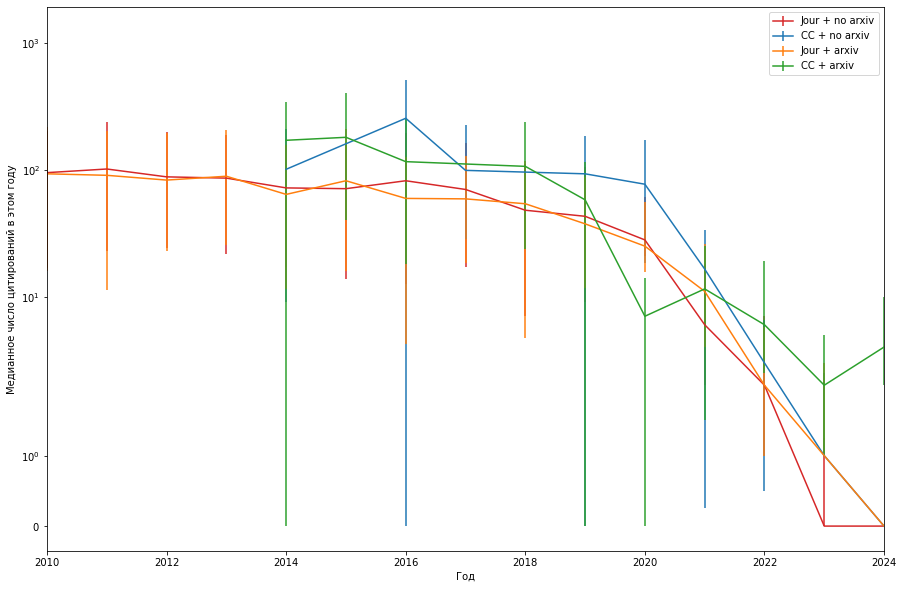

In [9]:
plot_stats(df_icar, years=[2010, 2024])

*Ремарка:*<br>
Icarus имеет очень богатую историю публикаций, однако мы ограничимся периодом, когда в нем появились публикации с сохранением авторского права и распространением публикаций по CC-BY.

**Выводы:**

Продемонстрированный ранее тренд для публикаций значительно нарушается. Публикации с и без препринтов не имеют значимого отличия для публикаций в ограниченном доступе, а в публикациях с CC-BY тренд остается неочевидным.<br>
При этом наблюдается иное отличие: любые публикации с CC-BY имеют медианно большую цитируемость, чем таковые с передачей авторского права издателю и ограниченным доступом к публикации.

#### New Astronomy

Ранее очень популярный журнал с богатой историей, который в последние годы потерял свою привлекательность для авторов.<br>
Посвящен всем областям астрономии и астрофизики.

Статистика взята из [scimago](https://www.scimagojr.com/journalsearch.php?q=27730&tip=sid&clean=0):
```
h-index    = 72
SJR        = 0.409
Quartile   = Q3 
Cites/Doc. = 1.89

In [10]:
df_newa = journal_check('NewA')
print(f'Публикаций найдено: {len(df_newa)}')
df_newa.head(5)

Публикаций найдено: 2000


,alternate_bibcode,copyright,title,year,citation_count,free_copy,arxiv,pub_type
0,[2000astro.ph..3162S],(c) 2001 Elsevier Science B.V.,[GADGET: a code for collisionless and gasdynam...,2001,1410,False,True,2
1,[2023arXiv231019307P],(c) 2024 Elsevier B.V.,[Discovery of four new EL CVn-type binaries in...,2024,0,False,True,2
2,[2009arXiv0912.1056M],(c) 2009 Elsevier B.V.,[VISTA Variables in the Via Lactea (VVV): The ...,2010,794,False,True,2
3,[2023arXiv230808908S],(c) 2024 Elsevier B.V.,[A new look at the YY CrB binary system],2024,0,False,True,2
4,NaN,(c) 2024 Elsevier B.V.,[Spectral study of the planetary nebula NGC 2452],2024,0,False,False,0


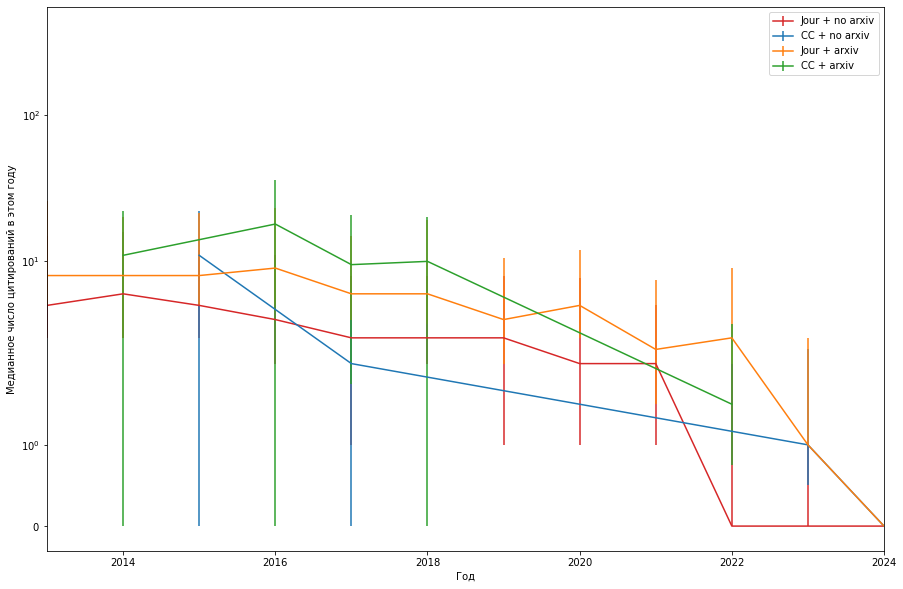

In [11]:
plot_stats(df_newa, years=[2013, 2024])

*Ремарка:*<br>
Как и в прошлый раз, журнал имеет очень богатую историю публикаций, однако мы ограничимся периодом, когда в нем появились публикации с сохранением авторского права и распространением публикаций по CC-BY.

**Выводы:**

На данном примере наблюдается уже устоявшийся тренд: публикации с препринтами на Arxiv имеют систематически большее число цитирований, чем таковые без препринтов.<br>
Здесь, однако, эта разница менее заметна ввиду в целом меньшей цитируемости публикаций у журнала.<br>
На большом промежутке в несколько лет наблюдается парадоксальный спад числа цитирований для публикаций в Open Access без препринтов по сравнению с ограниченным доступом без препринтов.

#### **Глобальный вывод:**
Первый и самый главный вывод, который подтверждается во всех продемонстрированных журналах:<br>
Позитивное влияние публикации препринтов на цитируемость статьи.

Второй аспект, который стоит отметить &mdash; это неоднозначные взаимоотношения между публикациями в Arxiv и публикациями в Open Access на странице журнала, которые, в теории, можно ожидать эквивалентными, но они таковыми не являются и, видимо, связаны с в целом цитируемостью и известностью журнала.

Лучшая гипотеза, которую я могу высказать в этом отношении:

Научное сообщество в контексте издателей и препринтов имеет два способа узнать о новой работе: увидеть препринт публикации на сайте вроде Arxiv или увидеть публикацию на сайте издателя/в рамках подписки.

Для журналов с высокой известностью, например, Icarus, второй вариант распространения является более актуальным, поскольку саму страницу журнала посещают чаще, а на сервисы рассылки подписано больше ученых и организаций. Охват аудитории, коррелирующий с числом цитирований, полученный от публикации препринта в этом отношении не играет большой роли из-за огромного потока препринтов, выкладываемых ежедневно без сортировки по журналу издателя и т.д., на фоне которых даже интересная ученым публикация может затеряться.

Для журналов, для которых посещаемость и охват персональной рассылки и собственного веб-сайта вторичен, как, например, все остальные примеры из нашего рассмотрения, публикация препринтов имеет большее значение и, зачастую, даже большее, чем публикация в открытом доступе.

Таким образом, похоже, что в отношении препринтов и открытого доступа иерархия значимости каждого из эффектов определяется в первую очередь отношением в охватах аудиторий сервера препринтов и журнала и известностью журнала.

На основе этой гипотезы можно провести численный анализ: в качестве бейз-лайна использовать цитируемость публикаций с передачей авторского права и без публикации препринта, для них получить в относительных единицах прирост в каждом из случаев и сравнить эти значения для множества различных журналов с разными уровнями цитируемости в поисках точке перехода.

Это, однако, требует более систематического поиска журналов, попадающих под описанные в начале критерии, а потому выходит за рамки этой работы.